Unified for all the PT regions

In [1]:
from categoriesDef import categories
cat = categories['low']

### Imports

In [2]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle, yaml
import time
from array import array
from multiprocessing import Pool
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [4]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [5]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

# Load data

In [6]:
dataDir = '../data/cmsRD'
datasets_loc = glob(dataDir + '/ParkingBPH*/*2018*B2JpsiKst_200124*')
lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
CMS_lumi.integrated_lumi = lumi_tot

Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part2_v2 0.03
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part2_v2 0.66
Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part1_v2 0.03
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part1_v2 1.24
Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part4_v2 0.03
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part4_v2 1.23
Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part3_v2 0.03
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part3_v2 1.28
Run2018C-05May2019-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part0_v2 0.03
Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_200124
HLT_Mu7_IP4_part0_v2 1.24
Total lumi: 5.80 fb^-1


In [7]:
dsetRD_loc = '../data/cmsRD/skimmed/B2JpsiKst_200124_{}.root'.format(cat.name)

fRD_skimmed = rt.TFile.Open(dsetRD_loc, 'READ')
tRD_skimmed = fRD_skimmed.Get('Tevts')

N_sel_per_fb = tRD_skimmed.GetEntries()/lumi_tot
print 'Selected events per fb: {:.0f}'.format(N_sel_per_fb)

Selected events per fb: 2273


# Analyze data

### Fit the whole dataset

In [8]:
width = 0.005 #GeV
m_min = 5.1
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', 'Events'],
                binning=np.arange(start=m_min, stop=5.45, step=width)
               )
tRD_skimmed.Project('h', 'mass_mumupiK')
h.Sumw2()

In [9]:
N = h.GetNbinsX()
m_max = h.GetBinCenter(N) +  0.5*h.GetBinWidth(N)
mass = rt.RooRealVar('mass_mumupiK', 'm_{#mu#mu#piK}', m_min, m_max, 'GeV')

mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
sigmaN = rt.RooRealVar('sigmaN', '#sigma_{N}', 0.02, 0.00005, 0.1, 'GeV') 
sigmaW = rt.RooRealVar('sigmaW', '#sigma_{W}', 0.06, 0.00005, 0.1, 'GeV') 
gausN = rt.RooGaussian('gausN','gausN', mass, mean, sigmaN)
gausW = rt.RooGaussian('gausW','gausW', mass, mean, sigmaW)
fN = rt.RooRealVar('fN', 'f_{N}', 0.5, 0.01, 0.99)
pdf_sig = rt.RooAddPdf('dGaus', 'sig pdf', rt.RooArgList(gausN, gausW), rt.RooArgList(fN))

# mean = rt.RooRealVar('mean', '#mu', m_B0, 3, 7, 'GeV')
# sigma = rt.RooRealVar('sigma', '#sigma', 0.03, 0.00005, 0.1, 'GeV')
# pAsym = rt.RooRealVar('pAsym', '#alpha', 0, -1, 1)
# # pAsym.setConstant(rt.kTRUE)
# rho1 = rt.RooRealVar('rho1', '#rho_{1}', -0.5, -10, 0)
# # rho1.setConstant(rt.kTRUE)
# rho2 = rt.RooRealVar('rho2', '#rho_{2}', 0.5, 0, 10)
# pdf_sig = rt.RooBukinPdf('bukin','sig pdf', mass, mean, sigma, pAsym, rho1, rho2)

N_tot = h.Integral(1, h.GetNbinsX())
nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 100*N_tot)
pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)

In [10]:
lam = rt.RooRealVar('lam', '#lambda', -2.1, -100, -0.1, 'GeV^{-1}')
pdf_bkg = rt.RooExponential('expo', 'bkg pdf', mass, lam)

# a0 = rt.RooRealVar('a0', 'a0', 10, 0, 100)
# a1 = rt.RooRealVar('a1', 'a1', -0.1, -10, 100)
# a2 = rt.RooRealVar('a2', 'a2', 0.1, -100, 100)
# pdf_bkg = rt.RooPolynomial('poly', 'bkg pdf', mass, rt.RooArgList(a1, a2), 1)

nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0.1*N_tot, 0, 100*N_tot)
pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)

In [11]:
data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)

pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())

dof = h.GetNbinsX()-fr.floatParsFinal().getSize()
chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
pval = rt.ROOT.Math.chisquared_cdf_c(chi2.getVal(), dof)
print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2.getVal(), dof, pval)

print 'Total: Nsig = {:.0f}, Nbkg = {:.0f}'.format(nsig.getVal(), nbkg.getVal())
N_sig_per_fb = nsig.getVal()/lumi_tot
dN_sig_per_fb = nsig.getError()/lumi_tot
print 'Signal events per fb: {:.0f}'.format(N_sig_per_fb)

chi2: 77.3/63 0.106
Total: Nsig = 9529, Nbkg = 1980
Signal events per fb: 1643


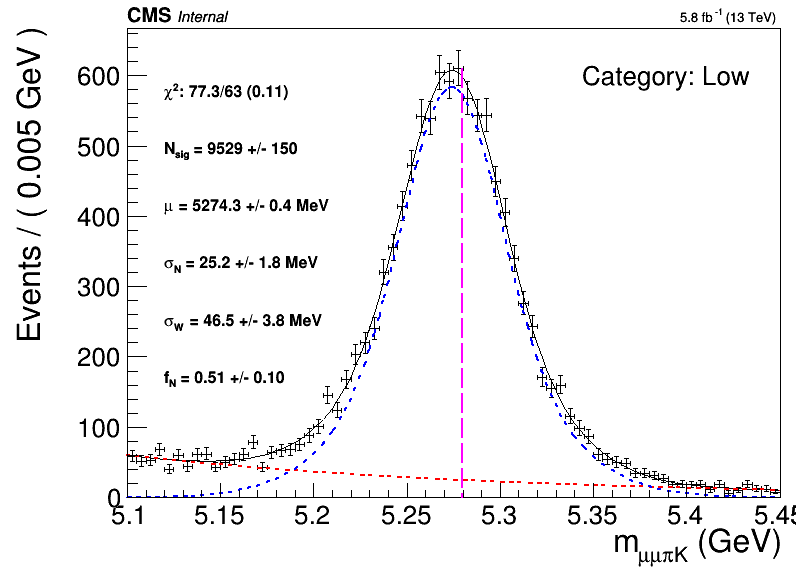

In [12]:
frame = mass.frame(rf.Title(""))
data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(h.GetLineColor()), rf.LineColor(h.GetLineColor()), rf.MarkerStyle(15))
pdf_tot.plotOn(frame, rf.LineColor(h.GetLineColor()), rf.LineWidth(1))
pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(rt.kRed), rf.LineWidth(2), rf.LineStyle(7))
pdf_tot.plotOn(frame, rf.Components('esig'), rf.LineColor(rt.kBlue), rf.LineWidth(2), rf.LineStyle(7))

x_min = h.binning[1] + (h.binning[-1]-h.binning[1])*0.03
x_max = h.binning[1] + (h.binning[-1]-h.binning[1])*0.3
pTxt = rt.TPaveText(x_min, 0.2*h.GetMaximum(), x_max, h.GetMaximum())
pTxt.SetBorderSize(0)
pTxt.SetFillStyle(0)
pTxt.SetTextAlign(11)
pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2.getVal(), dof, pval))
pTxt.AddText('N_{{sig}} = {:.0f} +/- {:.0f}'.format(nsig.getVal(), nsig.getError()))

pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
pTxt.AddText('#sigma_{{N}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaN.getVal(), 1e3*sigmaN.getError()))
pTxt.AddText('#sigma_{{W}} = {:.1f} +/- {:.1f} MeV'.format(1e3*sigmaW.getVal(), 1e3*sigmaW.getError()))
pTxt.AddText('f_{{N}} = {:.2f} +/- {:.2f}'.format(fN.getVal(), fN.getError()))

# pTxt.AddText('#mu = {:.1f} +/- {:.1f} MeV'.format(1e3*mean.getVal(), 1e3*mean.getError()))
# pTxt.AddText('#sigma = {:.1f} +/- {:.1f} MeV'.format(1e3*sigma.getVal(), 1e3*sigma.getError()))
# pTxt.AddText('#alpha = {:.3f} +/- {:.3f}'.format(pAsym.getVal(), pAsym.getError()))
# pTxt.AddText('#rho_{{1}} = {:.3f} +/- {:.3f}'.format(rho1.getVal(), rho1.getError()))
# pTxt.AddText('#rho_{{2}} = {:.3f} +/- {:.3f}'.format(rho2.getVal(), rho2.getError()))

catText = rt.TLatex()
catText.SetTextAlign(31)
catText.SetTextSize(0.06)
catText.SetTextFont(42)
catText.SetTextSize(0.05)

c = drawOnCMSCanvas(CMS_lumi, frame)
cl.DrawLine(m_B0, 0, m_B0, h.GetMaximum());
pTxt.Draw()
catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name))
c.SaveAs('../data/calibration/B0pTspectrum/fig/MassMuMuPiK_data_' + cat.name + '.png')

### Make sDataset

In [13]:
v_B_pt = rt.RooRealVar('B_pt', 'p_{T}^{(B)}', 0, 500, 'GeV')
v_B_eta = rt.RooRealVar('B_eta', '#eta^{(B)}', -3, 3, 'GeV')
v_trgMu_pt = rt.RooRealVar('trgMu_pt', '#mu_{trg} p_{T}', 0, 1000, 'GeV')
v_N_vtx = rt.RooRealVar('N_vtx', 'N_{vtx}', 0, 1e3)

rt.RooAbsData.setDefaultStorageType(rt.RooAbsData.Tree)
ds = rt.RooDataSet('ds', 'ds', tRD_skimmed, rt.RooArgSet(mass, v_B_eta, v_B_pt, v_trgMu_pt, v_N_vtx))
ds.convertToTreeStore()

In [14]:
sData = rt.RooStats.SPlot('sData', 'sData', ds, pdf_tot, rt.RooArgList(nsig, nbkg))
sData.GetYieldFromSWeight('nsig_sw')

9529.658164143912

In [15]:
f_sw = rt.TFile(dsetRD_loc.replace('.root', '_sw.root'), 'RECREATE')
ds.convertToTreeStore()
auxTree = ds.tree()
auxTree.Write()
f_sw.Close()

In [16]:
f_sw = rt.TFile.Open(dsetRD_loc.replace('.root', '_sw.root'), 'READ')
tRD_sw = f_sw.Get('merged')

# Load MC

In [17]:
dsetMC_loc = '../data/cmsMC_private/BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU20_10-2-3/'
dsetMC_loc += 'ntuples_B2JpsiKst/skimmed/{}.root'.format(cat.name)

fMC_skimmed = rt.TFile.Open(dsetMC_loc, 'READ')
tMC_skimmed = fMC_skimmed.Get('Tevts')

In [18]:
test_loc = '../data/cmsMC_private/BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgenFSR_SVV_PU20_10-2-3/'
test_loc += 'ntuples_B2JpsiKst/skimmed/{}.root'.format(cat.name)

fMC_test = rt.TFile.Open(test_loc, 'READ')
tMC_test = fMC_test.Get('Tevts')

In [19]:
effMCgen = yaml.load(open(dsetMC_loc[:dsetMC_loc.find('ntuples')] + 'effMCgenerator.yaml', 'r'))

In [20]:
decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))['JPsiKst']

In [21]:
effCAND = yaml.load(open(dsetMC_loc[:dsetMC_loc.find('skimmed')] + 'effCAND.yaml', 'r'))

In [22]:
aux = open(dsetMC_loc[:-4] + 'log', 'r').readlines()[-1][:-1].split(' ')
effSkim = [float(aux[1])*1e-2, float(aux[3])*1e-2]

In [23]:
xsec_eff = 1
dxsec = 0
for f, df in [effMCgen['xsec'], effMCgen['effGEN'], decayBR, effCAND['effCAND'], effSkim]:
    xsec_eff *= f
    dxsec += np.square(df/f)
dxsec = xsec_eff * np.sqrt(dxsec)
print '\nExpected evts/fb: {:.0f} +/- {:.0f}'.format(xsec_eff, dxsec)
print '\n'

r = N_sig_per_fb/xsec_eff
dr = r*np.hypot(dxsec/xsec_eff, dN_sig_per_fb/N_sig_per_fb)
print 'Ratio with observed: {:.0f}/{:.0f} = {:.2f} +/- {:.2f}'.format(N_sig_per_fb, xsec_eff, r, dr)
with open('../data/calibration/totalRate/ratioB02JPsiKst_{}.txt'.format(cat.name), 'w') as faux:
    faux.write('{:.3f} {:.3f}\n'.format(r,dr))


Expected evts/fb: 648 +/- 26


Ratio with observed: 1643/648 = 2.54 +/- 0.11


# Compare

### Closure variables

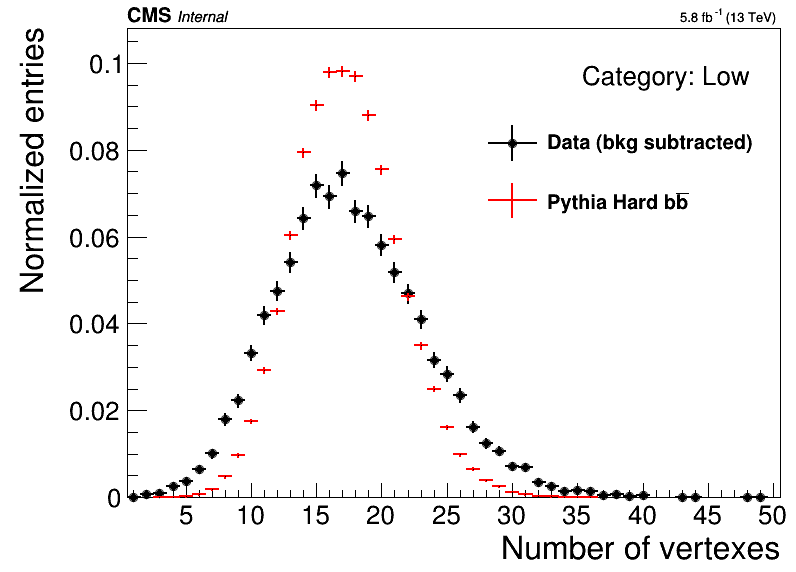

In [24]:
b=[50, 0.5, 50.5]
hRD = create_TH1D(np.zeros(0), name='hRD',
                title='',
                axis_title=['Number of vertexes', 'Normalized entries'],
                binning=b
               )
tRD_sw.Project('hRD', 'N_vtx', 'L_nsig/(L_nsig+L_nbkg)')
hRD.Sumw2()
hRD.Scale(1./hRD.Integral())
hRD.SetMarkerStyle(15)

hMC = create_TH1D(np.zeros(0), name='hMC',
                  title = 'Pythia Hard b#bar{b}',
                  binning=hRD.binning)
tMC_skimmed.Project('hMC', 'N_vtx')
hMC.Sumw2()
hMC.Scale(1./hMC.Integral())
hMC.SetLineColor(rt.kRed)
    
leg = rt.TLegend(0.6, 0.6, 0.95,0.8)
leg.SetBorderSize(0)
leg.AddEntry(hRD, 'Data (bkg subtracted)', 'lep')
leg.AddEntry(hMC, 'Pythia Hard b#bar{b}', 'le')

CMS_lumi.integrated_lumi = lumi_tot
m = SetMaxToMaxHist([hRD, hMC])
c = drawOnCMSCanvas(CMS_lumi, [hRD, hMC], 'same')
leg.Draw()
catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name))
c.SaveAs('../data/calibration/B0pTspectrum/fig/PUcomaprison_' + cat.name + '.png')

### Load MC corrections

In [25]:
loc = '../data/calibration/triggerScaleFactors/'
fTriggerSF = rt.TFile.Open(loc + 'HLT_' + cat.trg + '_SF.root', 'READ')
hTriggerSF = fTriggerSF.Get('hSF_HLT_' + cat.trg)

auxArrMC = rtnp.tree2array(tMC_skimmed, branches=['trgMu_pt', 'trgMu_eta', 'trgMu_sigdxy'])
trgSF = np.ones(auxArrMC.shape[0])
for i, (pt, eta, ip) in enumerate(auxArrMC):
    ix = hTriggerSF.GetXaxis().FindBin(pt)
    iy = hTriggerSF.GetYaxis().FindBin(ip)
    iz = hTriggerSF.GetZaxis().FindBin(np.abs(eta))
    trgSF[i] = hTriggerSF.GetBinContent(ix, iy, iz)

In [26]:
fMuonIDSF = rt.TFile.Open('../data/calibration/muonIDscaleFactors/Run2018ABCD_SF_MuonID_Jpsi.root', 'READ')
hMuonIDSF = fMuonIDSF.Get('NUM_SoftID_DEN_genTracks_pt_abseta')

auxArrMC = rtnp.tree2array(tMC_skimmed, branches=['MC_mup_pt', 'MC_mup_eta', 'MC_mum_pt', 'MC_mum_eta'])
muonSF = np.ones(auxArrMC.shape[0])
for i, (ptp, etap, ptm, etam) in enumerate(auxArrMC):
    ix = hMuonIDSF.GetXaxis().FindBin(min(39.9,ptp))
    iy = hMuonIDSF.GetYaxis().FindBin(np.abs(etap))
    wp = hMuonIDSF.GetBinContent(ix, iy)
    ix = hMuonIDSF.GetXaxis().FindBin(min(39.9,ptm))
    iy = hMuonIDSF.GetYaxis().FindBin(np.abs(etam))
    wm = hMuonIDSF.GetBinContent(ix, iy)
    muonSF[i] = wp * wm

In [27]:
auxArrMC = rtnp.tree2array(tMC_skimmed, branches=['MCidxCandMatch'])
print 'MC purity: {:.1f}%'.format(100*np.sum(auxArrMC['MCidxCandMatch'] == 1)/float(auxArrMC['MCidxCandMatch'].shape[0]))

MC purity: 98.0%


In [28]:
print np.sum(trgSF)/tMC_skimmed.GetEntries()
print np.sum(muonSF)/tMC_skimmed.GetEntries()
print np.sum(muonSF*trgSF)/tMC_skimmed.GetEntries()

0.9482953337566349
0.9906450978392776
0.9394265266113765


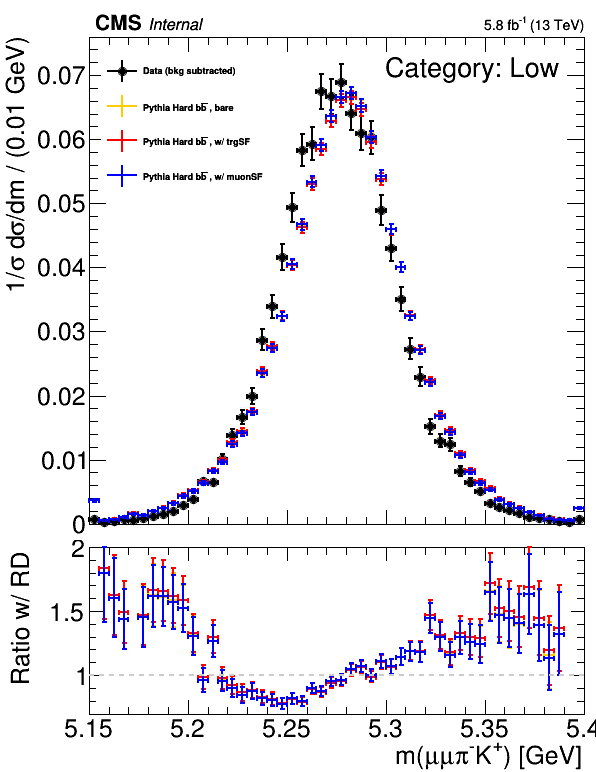

In [29]:
b=[50, 5.15, 5.4]

aux = rtnp.tree2array(tRD_sw, branches=['mass_mumupiK', 'L_nsig/(L_nsig+L_nbkg)'])
hRD = create_TH1D(aux['mass_mumupiK'], name='hRD', title='RD',
                  weights=aux['L_nsig/(L_nsig+L_nbkg)'],
                  axis_title=['m(#mu#mu#pi^{-}K^{+}) [GeV]', '1/#sigma d#sigma/dm / '+'({:.2f} GeV)'.format((b[2]-b[1])/b[0])],
                  binning=b,
                  opt='overflow+underflow'
                 )
hRD.Sumw2()
hRD.Scale(1./hRD.Integral())
hRD.SetMarkerStyle(15)

aux = rtnp.tree2array(tMC_skimmed, branches=['mass_mumupiK'])
hMCbare = create_TH1D(aux['mass_mumupiK'], name='hMCbare',
                  title = 'Pythia Hard b#bar{b}',
                  binning=hRD.binning, opt='overflow+underflow')
hMCbare.Sumw2()
hMCbare.Scale(1./hMCbare.Integral())
hMCbare.SetLineColor(rt.kOrange)
    
hMC = create_TH1D(aux['mass_mumupiK'], name='hMC', weights=trgSF,
                  binning=hRD.binning, opt='overflow+underflow')
hMC.Sumw2()
hMC.Scale(1./hMC.Integral())
hMC.SetLineColor(rt.kRed)

hMC2 = create_TH1D(aux['mass_mumupiK'], name='hMC2', weights=muonSF,
                  binning=hRD.binning, opt='overflow+underflow')
hMC2.Sumw2()
hMC2.Scale(1./hMC2.Integral())
hMC2.SetLineColor(rt.kBlue)

leg = rt.TLegend(0.17, 0.75, 0.45,0.93)
leg.SetBorderSize(0)
leg.AddEntry(hRD, 'Data (bkg subtracted)', 'lep')
leg.AddEntry(hMCbare, 'Pythia Hard b#bar{b} , bare', 'le')
leg.AddEntry(hMC, 'Pythia Hard b#bar{b} , w/ trgSF', 'le')
leg.AddEntry(hMC2, 'Pythia Hard b#bar{b} , w/ muonSF', 'le')

CMS_lumi.extraText = 7*' ' + 'Internal'
CMS_lumi.integrated_lumi = lumi_tot
c = make_ratio_plot([hRD, hMCbare, hMC, hMC2], leg_pos=None, ratio_bounds=[0.7,2])
c.pad1.SetTopMargin(0.07)
CMS_lumi.CMS_lumi(c, -1, 0)
c.Draw()
catText.DrawLatexNDC(0.95, 0.9, 'Category: {}'.format(cat.name))
leg.Draw()
c.SaveAs('../data/calibration/B0pTspectrum/fig/massComaprison_' + cat.name + '.png')

### The true B spectrum

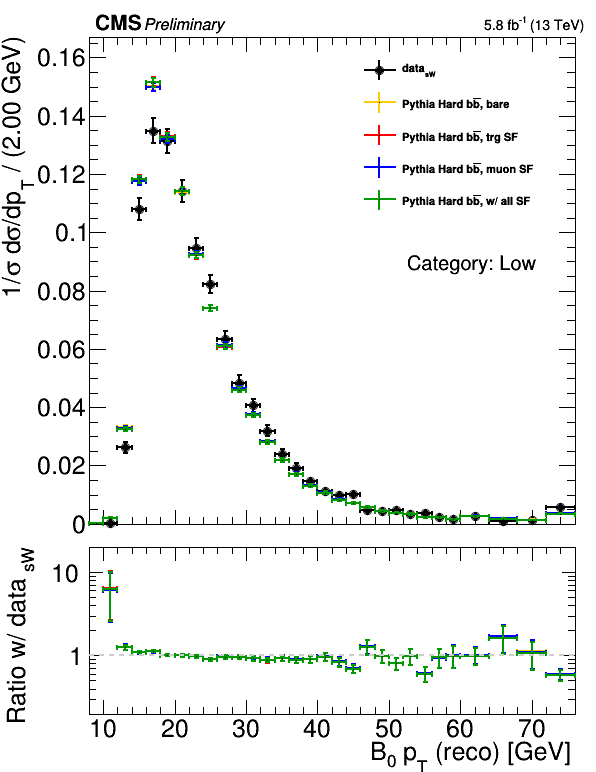

In [30]:
b = {'Low': array('d', list(np.arange(8, 60, 2)) + list(np.arange(60, 80, 4))),
     'Mid': array('d', list(np.arange(10, 60, 2)) + list(np.arange(60, 80, 4))),
     'High': array('d', list(np.arange(10, 90, 2)) + list(np.arange(90, 120, 10)))
    }
     
binWdith = b[cat.name][1] - b[cat.name][0]
aux = rtnp.tree2array(tRD_sw, branches=['B_pt', 'nsig_sw'])
hRD = create_TH1D(aux['B_pt'], name='hRD',
                  weights=aux['nsig_sw'],
                  title='data_{sW}',
                  axis_title=['B_{0} p_{T} (reco) [GeV]', 
                              '1/#sigma d#sigma/dp_{T} / '+'({:.2f} GeV)'.format(binWdith)],
                  binning=b[cat.name],
                  opt='overflow+underflow'
                 )
hRD.Sumw2()
hRD.Scale(1./hRD.Integral())
hRD.SetMarkerStyle(15)

aux = rtnp.tree2array(tMC_skimmed, branches=['B_pt'])
hMCb = create_TH1D(aux['B_pt'], name='hMCb',
                  title = 'Pythia Hard b#bar{b}, bare',
                  binning=hRD.binning, opt='overflow+underflow')
hMCb.Sumw2()
hMCb.Scale(1./hMCb.Integral())
hMCb.SetLineColor(rt.kOrange)

hMC1 = create_TH1D(aux['B_pt'], name='hMC1', weights=trgSF,
                  title = 'Pythia Hard b#bar{b}, trg SF',
                  binning=hRD.binning, opt='overflow+underflow')
hMC1.Sumw2()
hMC1.Scale(1./hMC1.Integral())
hMC1.SetLineColor(rt.kRed)

hMC2 = create_TH1D(aux['B_pt'], name='hMC2', weights=muonSF,
                  title = 'Pythia Hard b#bar{b}, muon SF',
                  binning=hRD.binning, opt='overflow+underflow')
hMC2.Sumw2()
hMC2.Scale(1./hMC2.Integral())
hMC2.SetLineColor(rt.kBlue)

hMC = create_TH1D(aux['B_pt'], name='hMC', weights=muonSF*trgSF,
                  title = 'Pythia Hard b#bar{b}, w/ all SF',
                  binning=hRD.binning, opt='overflow+underflow')
hMC.Sumw2()
hMC.Scale(1./hMC.Integral())
hMC.SetLineColor(rt.kGreen+2)

CMS_lumi.extraText = '      Preliminary'
c = make_ratio_plot([hRD, hMCb, hMC1, hMC2, hMC], ratio_bounds=[0.2, 20], draw_opt='E1')
CMS_lumi.CMS_lumi(c, -1, 0)
c.pad1.SetTopMargin(0.07)
c.pad1.SetRightMargin(0.035)
c.pad2.SetRightMargin(0.035)
c.pad2.SetLogy()
c.leg.SetY2(0.9)
c.leg.SetY1(0.6)
c.leg.SetX1(0.6)
c.Draw()

c.pad1.cd()
catText.SetTextSize(0.04)
catText.DrawLatexNDC(0.9, 0.5, 'Category: {}'.format(cat.name))
c.SaveAs('../data/calibration/B0pTspectrum/fig/B0pTcomaprison_' + cat.name + '.png')

In [31]:
uncertainty = 0.3
dic = {'pt':[], 'w':[], 'w_err':[], 'wUp':[], 'wDown':[]}

def f_arb_1(x, value_at_beg):
    center = 0.5*(hRD.binning[-1] + hRD.binning[0])
    k = (value_at_beg-1)/(hRD.binning[1] -  center)
    return k*(x - center)+1

def f_arb_2(x, pivFrac=0.3, lamToEnd=3):
    xPiv = pivFrac*(hRD.binning[-1] + hRD.binning[0])
    if x <= xPiv:
        dx = xPiv - x
        lam = (xPiv - hRD.binning[0])/lamToEnd
        sf = 1 - np.exp(-dx/lam)
        return -sf
    elif x > xPiv:
        dx = x - xPiv
        lam = (hRD.binning[-1] - xPiv)/lamToEnd
        sf = 1 - np.exp(-dx/lam)
        return sf

fout = open('../data/calibration/B0pTspectrum/pwWeights_{}.txt'.format(cat.name), 'w')
fout.write('#'+'\t'.join(['pt','w', 'w_err', 'wUp', 'wDown'])+'\n')
for ib in range(1, hRD.GetNbinsX()+1):
    n = max(0, hRD.GetBinContent(ib))
    d = hMC.GetBinContent(ib)
    en = 0.
    ed = 0.
    if n > 0: en = hRD.GetBinError(ib)/n
    if d > 0: ed = hMC.GetBinError(ib)/d
    r = n/d
    dic['w'].append(r)
    if en != 0 and ed != 0:
        dr = r*np.hypot(en, ed)
    elif en == 0:
        dr = 0.5
    dic['w_err'].append(dr)
    pt = hRD.GetBinCenter(ib)
    dic['pt'].append(pt)
    
#     dic['wUp'].append(r * f_arb_1(pt, 1. - uncertainty))
#     dic['wDown'].append(r * f_arb_1(pt, 1. + uncertainty))
    dic['wUp'].append(max(0, r + dr *f_arb_2(pt)))
    dic['wDown'].append(max(0, r - dr * f_arb_2(pt)))
    
    fout.write('\t'.join(map(lambda x: '{:.3f}'.format(x), [pt, r, dr, dic['wUp'][-1], dic['wDown'][-1]]))+'\n')
fout.close()

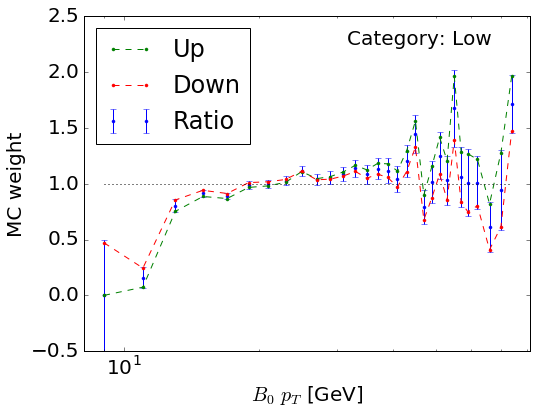

In [32]:
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(8,6))
plt.errorbar(dic['pt'], dic['w'], yerr=dic['w_err'], fmt='.', label='Ratio')
plt.plot(dic['pt'], dic['wUp'], '.--', label='Up')
plt.plot(dic['pt'], dic['wDown'], '.--', label='Down')
plt.plot(dic['pt'] , [1]*len(dic['pt']), ':k')
plt.legend(loc='best')
plt.xlabel('$B_0\ p_T$ [GeV]')
plt.ylabel('MC weight')
_, ymax = plt.ylim()
plt.xlim(0.9*np.min(dic['pt']), 1.1*np.max(dic['pt']))
plt.text(0.9*np.max(dic['pt']) ,ymax*0.9, 'Category: ' + cat.name, horizontalalignment='right')
plt.xscale('log')
plt.savefig('../data/calibration/B0pTspectrum/fig/weightsVSpt_' + cat.name + '.png')

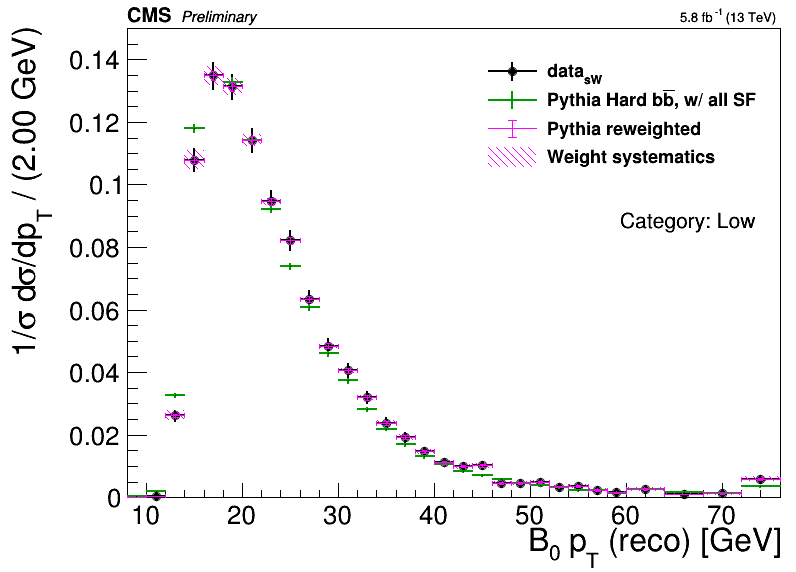

In [33]:
h_var = {}
colors = [5,6,8]
for k in ['central', 'up', 'down']:
    h_var[k] = hMC.Clone('hMC_'+k)
    h_var[k].SetTitle(k)
    h_var[k].SetLineColor(colors[0])
    h_var[k].SetMarkerColor(colors[0])
    h_var[k].SetMarkerStyle(rt.kCircle)
    colors.pop(0)
    
for ib in range(1, hRD.GetNbinsX()+1):
    x = hRD.GetBinCenter(ib)
    y = hMC.GetBinContent(ib)
    y_err = hMC.GetBinError(ib)
    h_var['central'].SetBinContent(ib, y*dic['w'][ib-1])
    h_var['central'].SetBinError(ib, y_err*dic['w'][ib-1])
    h_var['up'].SetBinContent(ib, y*dic['wUp'][ib-1])
    h_var['up'].SetBinError(ib, y_err*dic['wUp'][ib-1])
    h_var['down'].SetBinContent(ib, y*dic['wDown'][ib-1])    
    h_var['down'].SetBinError(ib, y_err*dic['wDown'][ib-1])
for h in h_var.values():
    h.Scale(1./h.Integral())
    
gr_stat = rt.TGraphAsymmErrors()
gr_sys = rt.TGraphAsymmErrors()
for ib in range(1, hRD.GetNbinsX()+1):
    x = hRD.GetBinCenter(ib)
    y = h_var['central'].GetBinContent(ib)
    gr_stat.SetPoint(ib-1, x, y)
    dx = 0.5*hMC.GetBinWidth(ib)
    dy = h_var['central'].GetBinError(ib)
    gr_stat.SetPointError(ib-1, dx, dx, dy, dy)
    
    dy_low = max(y-h_var['up'].GetBinContent(ib), y-h_var['down'].GetBinContent(ib))
    dy_up = max(h_var['up'].GetBinContent(ib)-y, h_var['down'].GetBinContent(ib)-y)
    gr_sys.SetPoint(ib-1, x, y)
    gr_sys.SetPointError(ib-1, dx, dx, dy_low, dy_up)
gr_stat.SetLineColor(6)
gr_stat.SetMarkerColor(6)
gr_sys.SetFillColor(6)
gr_sys.SetFillStyle(3005)
gr_sys.SetLineWidth(0)
    

leg = rt.TLegend(0.6, 0.7, 0.95,0.9)
leg.SetBorderSize(0)
leg.AddEntry(hRD, hRD.GetTitle(), 'lep')
leg.AddEntry(hMC, hMC.GetTitle(), 'le')
leg.AddEntry(gr_stat, 'Pythia reweighted', 'lep')
leg.AddEntry(gr_sys, 'Weight systematics', 'f')

hRD.GetYaxis().SetRangeUser(0, .15)
c = drawOnCMSCanvas(CMS_lumi, [hRD, hMC, gr_stat, gr_sys], ['', 'same', 'p', '2'])
leg.Draw()
catText.DrawLatexNDC(0.95, 0.6, 'Category: '+cat.name);

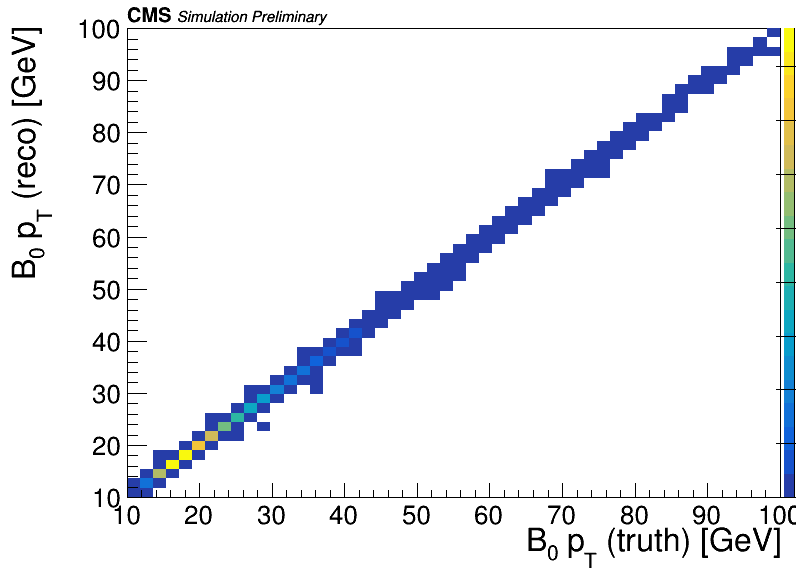

In [34]:
b=[50, 10, 100, 50, 10, 100]
hMC2D = create_TH2D(np.zeros((2,2)), name='hMC',
                title='',
                axis_title=['B_{0} p_{T} (truth) [GeV]', 'B_{0} p_{T} (reco) [GeV]', ''],
                binning=b
               )
tMC_skimmed.Project('hMC', 'B_pt:MC_B_pt', 'MCidxCandMatch')

CMS_lumi.extraText = '     Simulation Preliminary'
CMS_lumi.integrated_lumi = None
c = drawOnCMSCanvas(CMS_lumi, [hMC2D], ['colz'])

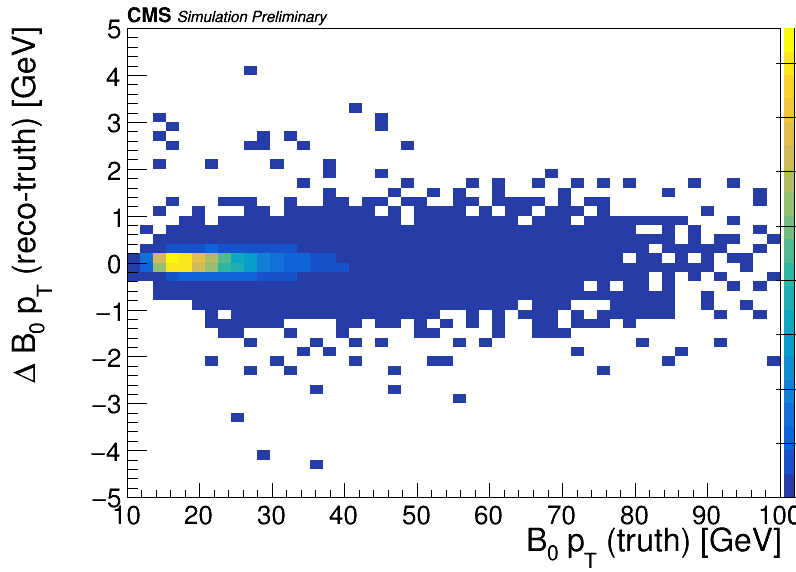

In [35]:
b=[50, 10, 100, 50, -5, 5]
hMC2D = create_TH2D(np.zeros((2,2)), name='hMC',
                title='',
                axis_title=['B_{0} p_{T} (truth) [GeV]', '#Delta B_{0} p_{T} (reco-truth) [GeV]', ''],
                binning=b
               )
tMC_skimmed.Project('hMC', 'B_pt - MC_B_pt:MC_B_pt', 'MCidxCandMatch')

CMS_lumi.extraText = '     Simulation Preliminary'
CMS_lumi.integrated_lumi = None
c = drawOnCMSCanvas(CMS_lumi, [hMC2D], ['colz'])

In [36]:
from pT_calibration_reader import pTCalReader
cal_pT = pTCalReader(calibration_file='../data/calibration/B0pTspectrum/pwWeights_{}.txt'.format(cat.name))

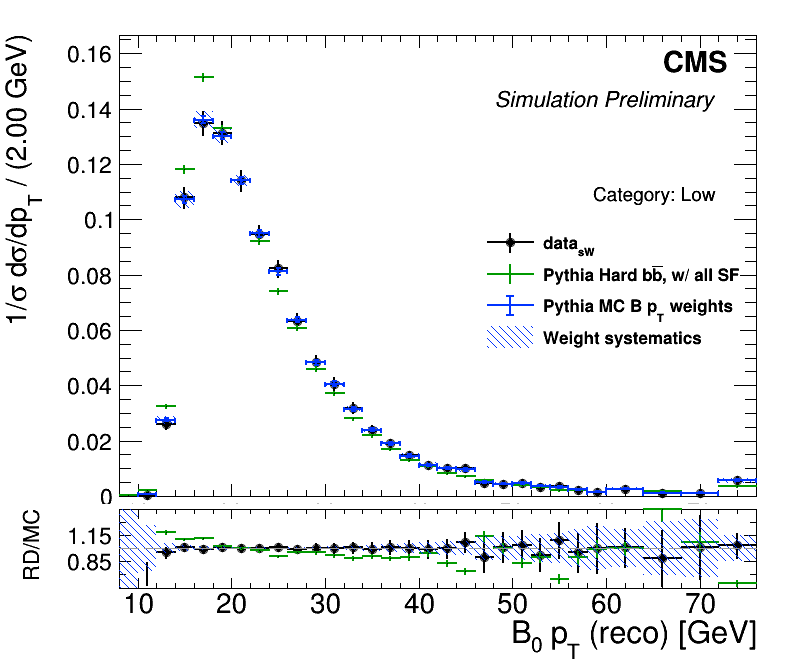

In [37]:
dSet_MC = rtnp.tree2array(tMC_skimmed)
h_var = {}
colors = [5,6,8]
for k in ['C', 'Up', 'Down']:
    h = create_TH1D(dSet_MC['B_pt'], name='h_var'+k, 
                    binning=hRD.binning, 
                    opt='underflow+overflow',
                    weights=cal_pT.f[k](dSet_MC['MC_B_pt'])*(trgSF*muonSF),
#                     weights=cal_pT.f[k](dSet_MC['MC_B_pt'])[sel]*(trgSF*muonSF)[sel],
                   )
    h.Scale(1./h.Integral())
    h_var[k] = h
    
gr_stat = rt.TGraphAsymmErrors()
gr_sys = rt.TGraphAsymmErrors()
h_dr = hRD.Clone('h_aux_dataratio')
h_mr = hMC.Clone('h_aux_MCratio')
g_up = rt.TGraph()
g_up.SetPoint(0, hMC.GetBinCenter(1)-0.5*hMC.GetBinWidth(1), 1)
g_down = rt.TGraph()
g_down.SetPoint(0, hMC.GetBinCenter(1)-0.5*hMC.GetBinWidth(1), 1)
for ib in range(1, hRD.GetNbinsX()+1):
    x = hRD.GetBinCenter(ib)
    y = h_var['C'].GetBinContent(ib)
    c = h_dr.GetBinContent(ib)
    e = h_dr.GetBinError(ib)
    h_dr.SetBinContent(ib, c/y)
    h_dr.SetBinError(ib, e/y)
    c = h_mr.GetBinContent(ib)
    e = h_mr.GetBinError(ib)
    h_mr.SetBinContent(ib, c/y)
    h_mr.SetBinError(ib, e/y)
    gr_stat.SetPoint(ib-1, x, y)
    dx = 0.5*hMC.GetBinWidth(ib)
    dy = h_var['C'].GetBinError(ib)
    gr_stat.SetPointError(ib-1, dx, dx, dy, dy)
    
    dy_low = max(y-h_var['Up'].GetBinContent(ib), y-h_var['Down'].GetBinContent(ib))
    dy_up = max(h_var['Up'].GetBinContent(ib)-y, h_var['Down'].GetBinContent(ib)-y)
    gr_sys.SetPoint(ib-1, x, y)
    gr_sys.SetPointError(ib-1, dx, dx, dy_low, dy_up)
    
    x_low = h_dr.GetBinCenter(ib) - 0.5*h_dr.GetBinWidth(ib)
    x_up = h_dr.GetBinCenter(ib) + 0.5*h_dr.GetBinWidth(ib)
    g_up.SetPoint(2*ib-1, x_low, (y+dy_up)/y)
    g_up.SetPoint(2*ib, x_up, (y+dy_up)/y)
    g_down.SetPoint(2*ib-1, x_low, (y-dy_low)/y)
    g_down.SetPoint(2*ib, x_up, (y-dy_low)/y)
g_up.SetPoint(2*ib+1, x_up, 1)
g_down.SetPoint(2*ib+1, x_up, 1)
gr_stat.SetLineColor(rt.kAzure)
gr_stat.SetLineWidth(2)
gr_stat.SetMarkerColor(rt.kAzure)
gr_sys.SetFillColor(rt.kAzure)
gr_sys.SetFillStyle(3005)
gr_sys.SetLineWidth(0)
    

leg = rt.TLegend(0.6, 0.3, 0.93,0.55)
leg.SetBorderSize(0)
leg.AddEntry(hRD, hRD.GetTitle(), 'lep')
leg.AddEntry(hMC, hMC.GetTitle(), 'le')
leg.AddEntry(gr_stat, 'Pythia MC B p_{T} weights', 'lep')
leg.AddEntry(gr_sys, 'Weight systematics', 'f')

SetMaxToMaxHist([hRD, hMC])
c = rt.TCanvas('c', 'c', 50, 50, 800, 700)
c.SetTickx(0)
c.SetTicky(0)

pad = rt.TPad('pmain', 'pmain', 0, 0.25, 1, 1)
pad.SetBottomMargin(0.015)
pad.SetTopMargin(0.07)
pad.SetRightMargin(0.05)
pad.SetLeftMargin(0.15)
pad.Draw()
pad.cd()
hRD.Draw()
hMC.Draw('same')
gr_stat.Draw('p')
gr_sys.Draw('2')
leg.Draw()
catText.DrawLatexNDC(0.9, 0.6, 'Category: {}'.format(cat.name));
CMS_lumi.CMS_lumi(pad, -1, 33, cmsTextSize=0.75*1.2, lumiTextSize=0.6*1.2)

c.cd()
pad = rt.TPad('ppull', 'ppull', 0, 0, 1, 0.25)
pad.SetBottomMargin(0.5)
pad.SetTopMargin(0.03)
pad.SetRightMargin(0.05)
pad.SetLeftMargin(0.15)
pad.Draw('same')
pad.cd()
h_dr.GetYaxis().SetTitle('RD/MC')
t = 0.15
h_dr.GetYaxis().SetRangeUser(1 - 3*t, 1 + 3*t)
h_dr.GetYaxis().SetTitleOffset(0.5)
h_dr.GetYaxis().SetTitleSize(0.14)
h_dr.GetYaxis().SetLabelSize(0.15)
h_dr.GetYaxis().SetNdivisions(-203)
h_dr.GetXaxis().SetTitleOffset(0.95)
h_dr.GetXaxis().SetTitleSize(0.2)
h_dr.GetXaxis().SetLabelSize(0.18)
h_dr.GetXaxis().SetTickSize(0.07)
h_dr.Draw('E0')
h_mr.Draw('sameE0')
g_up.SetFillColor(rt.kAzure)
g_up.SetFillStyle(3005)
g_up.Draw('F')
g_down.SetFillColor(rt.kAzure)
g_down.SetFillStyle(3005)
g_down.Draw('F')
gh_dr = rt.TGraphErrors()
for i in range(1, h_dr.GetNbinsX()+1):
    gh_dr.SetPoint(i-1, h_dr.GetBinCenter(i), h_dr.GetBinContent(i))
    gh_dr.SetPointError(i-1, h_dr.GetBinError(i))
gh_dr.SetLineColor(h_dr.GetLineColor())
gh_dr.Draw('P0')
ax = h_dr.GetYaxis()
ax.ChangeLabel(1, -1, -1, -1, -1, -1, ' ')
ax.ChangeLabel(4, -1, -1, -1, -1, -1, ' ')

l = rt.TLine()
l.SetLineColor(rt.kGray+1)
l.SetLineWidth(1)
l.SetLineStyle(9)
x_low = h_dr.GetBinCenter(1)-0.5*h_dr.GetBinWidth(1)
x_high = h_dr.GetBinCenter(h_dr.GetNbinsX())+0.5*h_dr.GetBinWidth(h_dr.GetNbinsX())
l.DrawLine(x_low, 1, x_high, 1)


c.Draw()
c.SaveAs('../data/calibration/B0pTspectrum/fig/closure_' + cat.name + '.png')

In [38]:
for k in ['C', 'Up', 'Down']:
    weights = cal_pT.f[k](dSet_MC['MC_B_pt'])*(trgSF*muonSF)
    print k, np.sum(weights)/dSet_MC['B_pt'].shape[0]


C 0.9404546944234656
Up 0.9391042882057338
Down 0.9418145255921406
